# Forberedelsesoppgaver

In [1]:
import numpy as np
import matplotlib.pyplot as plt

---

# Del A - Fotontransportberegninger
## Oppgave 1

*Regn ut optisk penetrasjonsdybde i typisk menneskevev for bølgelengdene RGB-kameraet er sensitivt for*

I følge datablad til Raspberry pi kamera *Sony - IMX219* så er de mest sensitive områdene for kameraet på bølgelengdene; 600nm (rød), 530nm (blå) og 460nm (grønn).

Anta blodvolumsfraksjon på 1% og en blodoksygenering på 80%
Anta en absorpsjonskoeffisient med ekstra 25 m^-1 på grunn av andre faktorer som kollagen osv.

Formelen for penetrasjonsdybde $\delta$ (ved å gjøre antakelser om plan bølge inn og endimensjonal situasjon med homogent vev i alle retninger) er gitt ved:
$$\delta = \sqrt{\frac{1}{3(\mu_s^\prime + \mu_a)\mu_a}}$$
Der $\mu_s^\prime$ er redusert spredningskoeffisient og $\mu_a$ er absorpsjonskoeffisienten.

Penetrasjonsdybden er et mål på hvilken z inkommende energi har blitt redusert til $1/e \approx 36.4\%$.

In [2]:
# Get absorption coefficients of oxygenated and deoxygenated blood based on wavelength in nm
absorption_coef_oxygenated = np.genfromtxt("./assets/muabo.txt", delimiter=",")
absorption_coef_deoxygenated = np.genfromtxt("./assets/muabd.txt", delimiter=",")

RED_WAVELENGTH_NM = 600  # nm
GREEN_WAVELENGTH_NM = 530  # nm
BLUE_WAVELENGTH_NM = 460  # nm

wavelengths = np.array([RED_WAVELENGTH_NM, GREEN_WAVELENGTH_NM, BLUE_WAVELENGTH_NM])


def get_oxygenated_absorption_coef(x):
    """From the data in muabo.txt and muabd.txt,
    interpolate the absorption coefficient of oxygenated blood at the given wavelength."""
    return np.interp(
        x, absorption_coef_oxygenated[:, 0], absorption_coef_oxygenated[:, 1]
    )


def get_deoxygenated_absorption_coef(x):
    """From the data in muabo.txt and muabd.txt,
    interpolate the absorption coefficient of deoxygenated blood at the given wavelength.
    """
    return np.interp(
        x, absorption_coef_deoxygenated[:, 0], absorption_coef_deoxygenated[:, 1]
    )


BLOOD_VOLUME_FRACTION = 0.01  # Blood volume fraction, average blood amount in tissue (1%)
BLOOD_OXYGENATION = 0.8  # Blood oxygenation (80%)

# Absorption coefficient ($\mu_a$ in lab text)
# Units: 1/m
ABSORPTION_COEFF_OTHER = 25  # Background absorption due to collagen, et cetera

oxygenated_absorption_coef = get_oxygenated_absorption_coef(wavelengths)
deoxygenated_absorption_coef = get_deoxygenated_absorption_coef(wavelengths)

absorption_coef_blood = (
    oxygenated_absorption_coef * BLOOD_OXYGENATION
    + deoxygenated_absorption_coef * (1 - BLOOD_OXYGENATION)
)

# Total absorption coefficient $\mu_a$
mua = absorption_coef_blood * BLOOD_VOLUME_FRACTION + ABSORPTION_COEFF_OTHER

# reduced scattering coefficient ($\mu_s^\prime$ in lab text)
# the numerical constants are thanks to N. Bashkatov, E. A. Genina and
# V. V. Tuchin. Optical properties of skin, subcutaneous and muscle
# tissues: A review. In: J. Innov. Opt. Health Sci., 4(1):9-38, 2011.
# Units: 1/m
musr = 100 * (17.6 * (wavelengths / 500) ** -4 + 18.78 * (wavelengths / 500) ** -0.22)

# mua and musr are now available as shape (3,) arrays
# Red, green and blue correspond to indexes 0, 1 and 2, respectively

# Penetration depth $\delta$
# Units: m
delta = 1 / np.sqrt(3 * (musr + mua) * mua)
for i, wavelength in enumerate(wavelengths):

    print(f"Penetration depth for wavelength {wavelength} nm: {delta[i] * 1000:.3f} mm")

Penetration depth for wavelength 600 nm: 1.570 mm
Penetration depth for wavelength 530 nm: 0.686 mm
Penetration depth for wavelength 460 nm: 0.596 mm


## Oppgave 2
*Mål tykkelsen av fingeren din. Av lys som kommer inn i en slik finger, estimer med modellen
hvor stor prosentandel som kommer ut igjen på den andre siden, for hver av de tre fargeka-
nalene. Hva slags fingerdybde har du probet?*

Fingertykkelse målt: 1cm.

Diffusjonslikningen er gitt ved:
$$\phi(z) = \phi(0)\exp{(-Cz)}$$
der $C = \sqrt{3\mu_a(\mu_s^\prime + \mu_a)}$ og $\phi(0) = \frac{1}{2\delta \mu_a}$

Transmittans er enheten som forteller om mengen lys som kommer ut på andre siden av en finger i gitt av prosentandel.
$$T(z) = \frac{\phi(z)}{\phi(0)} = \exp{(-Cz)}$$

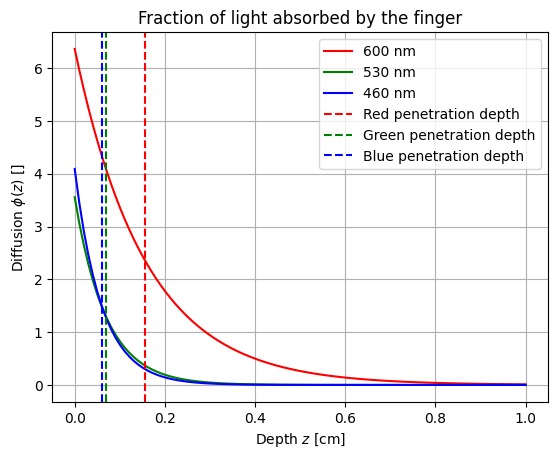

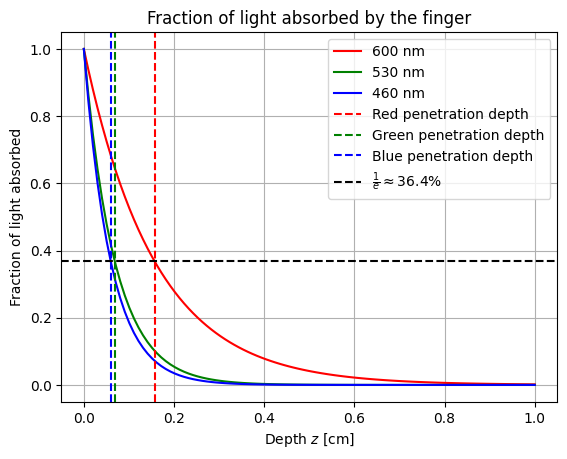

In [3]:
finger_width = 0.01  # m


# Calculate the fraction of light that is absorbed by the finger
def phi(z, *, mua: float, musr: float, penetration_depth: float) -> float:
    C = np.sqrt(3 * (musr + mua) * mua)
    return (1 / (2 * mua * penetration_depth)) * np.exp(-C * z)


def transmittance(z, *, mua: float, musr: float) -> float:
    C = np.sqrt(3 * (musr + mua) * mua)
    return np.exp(-C * z)


z = np.linspace(0, finger_width, 100)
colors = ["red", "green", "blue"]
for i, wavelength in enumerate(wavelengths):
    plt.plot(
        z * 100,
        phi(z, mua=mua[i], musr=musr[i], penetration_depth=delta[i]),
        color=colors[i],
        label=f"{wavelength} nm",
    )
plt.axvline(x=delta[0] * 100, color="red", linestyle="--", label="Red penetration depth")
plt.axvline(
    x=delta[1] * 100, color="green", linestyle="--", label="Green penetration depth"
)
plt.axvline(
    x=delta[2] * 100, color="blue", linestyle="--", label="Blue penetration depth"
)

plt.xlabel("Depth $z$ [cm]")
plt.ylabel("Diffusion $\phi(z)$ []")
plt.title("Fraction of light absorbed by the finger")
plt.legend()
plt.grid()

plt.figure()
for i, wavelength in enumerate(wavelengths):
    plt.plot(
        z * 100,
        transmittance(z, mua=mua[i], musr=musr[i]),
        color=colors[i],
        label=f"{wavelength} nm",
    )

plt.axvline(x=delta[0] * 100, color="red", linestyle="--", label="Red penetration depth")
plt.axvline(
    x=delta[1] * 100, color="green", linestyle="--", label="Green penetration depth"
)
plt.axvline(
    x=delta[2] * 100, color="blue", linestyle="--", label="Blue penetration depth"
)
plt.axhline(
    y=1 / np.e, color="black", linestyle="--", label=r"$\frac{1}{e} \approx 36.4\%$"
)

plt.xlabel("Depth $z$ [cm]")
plt.ylabel("Fraction of light absorbed")
plt.title("Fraction of light absorbed by the finger")
plt.legend()
plt.grid()
plt.show()

## Oppgave 3

*Hvis du måler reflektans, hvor dypt forventer du at signalet har probet fingeren på ulike
bølgelengder?*

For reflektans, så vil penetrasjonsdybden være gitt med avstanden inn i vevet før lyset snur igjen.
Det vil si at lyset må bevege seg dobbelt så langt som penetrasjonsdybden.

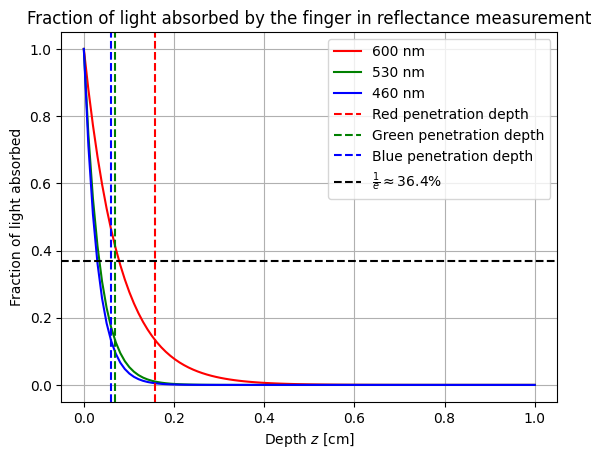

In [4]:
def reflectance(z, *, mua: float, musr: float) -> float:
    C = np.sqrt(3 * (musr + mua) * mua)
    return np.exp(-2 * C * z)


z = np.linspace(0, finger_width, 100)
colors = ["red", "green", "blue"]
for i, wavelength in enumerate(wavelengths):
    plt.plot(
        z * 100,
        reflectance(z, mua=mua[i], musr=musr[i]),
        color=colors[i],
        label=f"{wavelength} nm",
    )

plt.axvline(x=delta[0] * 100, color="red", linestyle="--", label="Red penetration depth")
plt.axvline(
    x=delta[1] * 100, color="green", linestyle="--", label="Green penetration depth"
)
plt.axvline(
    x=delta[2] * 100, color="blue", linestyle="--", label="Blue penetration depth"
)
plt.axhline(
    y=1 / np.e, color="black", linestyle="--", label=r"$\frac{1}{e} \approx 36.4\%$"
)
plt.grid()
plt.legend()
plt.xlabel("Depth $z$ [cm]")
plt.ylabel("Fraction of light absorbed")
plt.title("Fraction of light absorbed by the finger in reflectance measurement")
plt.show()

## Oppgave 4

*Anta en blodåre med diameter 300 µm. Regn ut hvor mye lys som når ut på den andre siden
av blodåren (blodvolumsfraksjon 100%), og sammenlign med hvor mye som når gjennom
et tilsvarende stykke vev (blodvolumsfraksjon 1%). Regn ut kontrasten. Hva sier dette om
forventet pulsamplitude?*

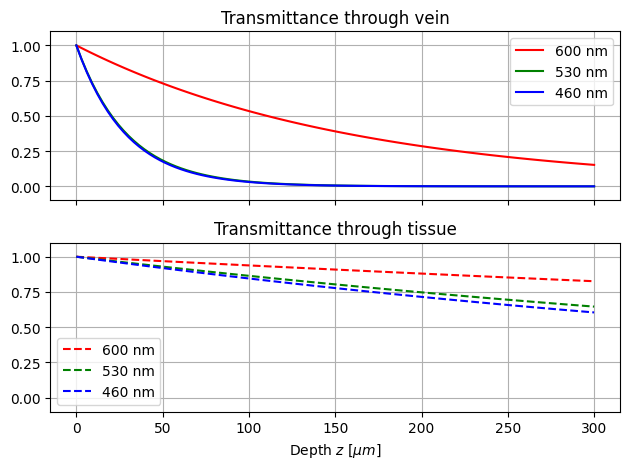

In [5]:
# lag nye mua med ny verdi for blodvolumsfraksjon
mua_1 = mua.copy()
BLOOD_VOLUME_FRACTION = 1  # Blood volume fraction, average blood amount in tissue (100%)

mua_100 = absorption_coef_blood * BLOOD_VOLUME_FRACTION + ABSORPTION_COEFF_OTHER

vein_width = 300e-6  # m

fig, ax = plt.subplots(2, 1, sharex=True, tight_layout=True)

z = np.linspace(0, vein_width, 100)
colors = ["red", "green", "blue"]
for i, wavelength in enumerate(wavelengths):
    ax[0].plot(
        z * 1e6,
        transmittance(z, mua=mua_100[i], musr=musr[i]),
        color=colors[i],
        label=f"{wavelength} nm",
    )
    ax[0].set_title("Transmittance through vein")
    ax[1].plot(
        z * 1e6,
        transmittance(z, mua=mua_1[i], musr=musr[i]),
        color=colors[i],
        linestyle="--",
        label=f"{wavelength} nm",
    )
    ax[1].set_title("Transmittance through tissue")

for a in ax:
    a.legend()
    a.grid()
    a.set_ylim(-0.1, 1.1)
plt.xlabel(r"Depth $z$ [$\mu m$]")
plt.show()

## Oppgave 5

*Hvilken fargekanal forventer du at vil fungere best til pulsmåling, og hvorfor?*

Den røde fargekanalen vil fungere best til pulsmåling på grunn av at mest mulig lys ved den bølgelengden vil komme seg igjennom fingeren.

---

# Del B - SNR
## Oppgave 1
*Du har trukket ut et pulssignal fra en kameravideo. Du kjenner amplituden på pulssignalet og sannsynlighetsfordelingen til støyen.*

*Hvordan kan du definere SNR dersom du er interessert i å se på hvor klart pulssignal du har?*

Signal til støyforhold (SNR) kan defineres på flere måter, det er avhengig om du ser på bildeklarhet, eller i pulsmåling-sammenheng.
For SNR i pulsmåling (sinusbølge) så tar man amplituden på signalet $A$ og deler på variansen til støyen $\sigma_{støy}$.
$$\text{SNR}_{pulsmåling} = \frac{A}{\sigma_{støy}}$$
For bildeklarhet, så kan man definere SNR som gjennomsnittsverdiene for pikslene i bildet, og deler på variansen på støyen i bildet.
$$\text{SNR}_{bildekvalitet} = \frac{\mu_{signal}}{\sigma_{støy}}$$

## Oppgave 2
*Hvordan kan du gjøre dette med en FFT-basert tilnærming om du ikke har en god karakteristikk av støyen eller pulsamplituden?*

Dersom du ikke har måling av variasjon til støyen, så kan man ty til FFT tilnærming. FFT-tilnærmingen er avhengig av at man vet hvilke frekvenskomponenter som er til stede i signalet. Basert på hvor presist man setter frekvensområdet som antas å inneholde kun signal.

Det å sette smalt frekvensområde så antas det at signalet har mere presis frekvens, at variansen på frekvensen til signalet er veldig lav. Dette er en vanskelig antakelse å gjøre med pulsmåling, dersom pulsen fort kan variere.